# Imports

Code is based on the work of Øyås & Stelling (2020).

In [1]:
import cobra
import gurobipy as grb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import csv

from collections import defaultdict, OrderedDict
from importlib import reload
from itertools import combinations, product, chain
from os.path import join
from scipy.stats import f_oneway

from mptool import *

%matplotlib inline

In [2]:
#ecm_result = pd.read_csv('../simple_networks/ecms/results/e_coli_core_ecm_df.csv', index_col = 0)
#ecm_df = pd.DataFrame(ecm_result)
#print(ecm_df)
#sum(ecm_df['objective'])

# Plot log results

In [3]:
# Load enumeration log
log_files = ['_copy_20220308_100541469702_random_incomplete_log.csv', 
             '_copy_20220308_100541497967_random_incomplete_log.csv', 
             '_copy_20220308_100541552921_random_incomplete_log.csv', 
             '_copy_20220308_100541605279_random_incomplete_log.csv', 
             '_copy_20220308_1005414029925_random_incomplete_log.csv', 
             '_copy_20220308_1005414208055_random_incomplete_log.csv',
             '_copy_20220308_1005414600976_random_incomplete_log.csv',
             '_copy_20220308_1005414873395_random_incomplete_log.csv',
             '_copy_20220308_1005415569336_random_incomplete_log.csv',
             '_copy_20220308_1005415933576_random_incomplete_log.csv', 
             '_copy_20220402_2029487486_random_incomplete_log.csv', 
             '_copy_20220402_20294875381_random_incomplete_log.csv', 
             '_copy_20220402_2029487129598_random_incomplete_log.csv', 
             '_copy_20220402_2029487296953_random_incomplete_log.csv', 
             '_copy_20220402_2029487452016_random_incomplete_log.csv', 
             '_copy_20220402_2029487568789_random_incomplete_log.csv', 
             '_copy_20220402_2029487610595_random_incomplete_log.csv', 
             '_copy_20220402_2029487674937_random_incomplete_log.csv', 
             '_copy_20220310_1233107150142_random_incomplete_log.csv']

log_list = []
for file in log_files:
    with open('results/mp/HM_model/{}'.format(file)) as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            log_list.append(row)

# Read column names
with open('results/mp/HM_model/_copy_20220308_100541469702_random_incomplete_log.csv') as file:
    lines = file.read()
    colnames = list(lines.split('\n', 1)[0].split(','))
colnames[5] = 't'

# Make dataframe
log_df = pd.DataFrame(log_list,columns=colnames)
log_df['t'] = log_df['t'].apply(pd.to_numeric)

# Add 'dt' column
log_df['dt'] = log_df['t']

base_indices = [i for i in chain(range(0,1000, 100), range(1000,10000, 1000))]
next_indices = [i for i in chain(range(100,1000, 100), range(1000,11000, 1000))]

for (i,j) in zip(base_indices, next_indices):
    log_df.dt[(i+1):j] = np.diff(log_df.t[i:j])

C:\Users\ylvaw\AppData\Local\Temp/ipykernel_6076/3286083554.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df.dt[(i+1):j] = np.diff(log_df.t[i:j])


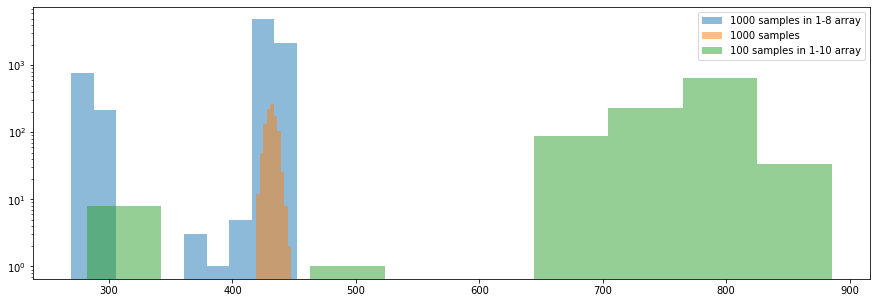

In [4]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.hist(log_df.dt[2000:], alpha=0.5, label='1000 samples in 1-8 array')
plt.hist(log_df.dt[1000:2000], alpha=0.5, label='1000 samples')
plt.hist(log_df.dt[:1000], alpha=0.5, label='100 samples in 1-10 array')
plt.legend(loc='upper right')
plt.yscale('log')
plt.savefig('results/figures/comptime_per_mp')

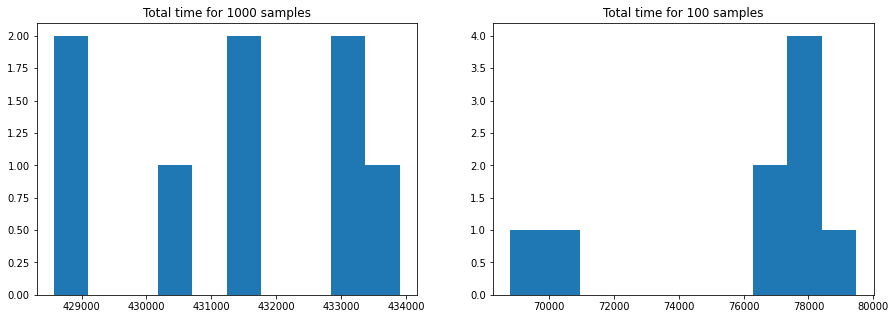

In [5]:
plt.rcParams["figure.figsize"] = [15, 5]

# Total time for 1000 samples and 100 samples:
k_totals = [log_df.t[i] for i in range(1999,9999, 1000)]
h_totals = [log_df.t[i] for i in range(99,999, 100)]


fig, axes = plt.subplots(1, 2)
plt.sca(axes[0])
plt.hist(k_totals)
plt.title('Total time for 1000 samples')

plt.sca(axes[1])
plt.hist(h_totals)
plt.title('Total time for 100 samples')

plt.savefig('results/figures/comptime_total_mp')

# Plot MPs

## My MPs

In [6]:
# Load MPs from my results
files = ['_copy_20220308_100541469702_random_incomplete_mps.csv', 
         '_copy_20220308_100541497967_random_incomplete_mps.csv', 
         '_copy_20220308_100541552921_random_incomplete_mps.csv', 
         '_copy_20220308_100541605279_random_incomplete_mps.csv', 
         '_copy_20220308_1005414029925_random_incomplete_mps.csv', 
         '_copy_20220308_1005414208055_random_incomplete_mps.csv',
         '_copy_20220308_1005414600976_random_incomplete_mps.csv',
         '_copy_20220308_1005414873395_random_incomplete_mps.csv',
         '_copy_20220308_1005415569336_random_incomplete_mps.csv',
         '_copy_20220308_1005415933576_random_incomplete_mps.csv', 
         '_copy_20220402_2029487486_random_incomplete_mps.csv', 
         '_copy_20220402_20294875381_random_incomplete_mps.csv', 
         '_copy_20220402_2029487129598_random_incomplete_mps.csv', 
         '_copy_20220402_2029487296953_random_incomplete_mps.csv', 
         '_copy_20220402_2029487452016_random_incomplete_mps.csv', 
         '_copy_20220402_2029487568789_random_incomplete_mps.csv', 
         '_copy_20220402_2029487610595_random_incomplete_mps.csv', 
         '_copy_20220402_2029487674937_random_incomplete_mps.csv', 
         '_copy_20220310_1233107150142_random_incomplete_mps.csv']

my_mps = set()
for filename in files:
    with open('results/mp/HM_model/{}'.format(filename), 'r') as f:
        for line in f:
            my_mps.add(frozenset(line.strip().split(',')))
len(my_mps)

10000

In [7]:
# Map organisms and metabolites
organisms = {
    'HS': 'Homo sapiens',
    'BT': 'Bacteroides thetaiotaomicron',
    'EC': 'Escherichia coli',
    'FP': 'Faecalibacterium prausnitzii',
    'LL': 'Lactococcus lactis',
    'LP': 'Lactobacillus plantarum',
    'ST': 'Streptococcus thermophilus',
}
mets1 = {
    'ala_L': 'alanine',
    'etoh': 'ethanol',
    'for': 'formate',
    'gly': 'glycine',
    'glyc': 'glycerol',
    'ile_L': 'isoleucine', # 'mal_L' : 'malate' 'ppa': 'propionate',
    'nac': 'niacin',
    'orn': 'ornithine',
    'succ': 'succinate'
}

mets2 = {
    'ala_L': 'alanine',
    'etoh': 'ethanol',
    'for': 'formate',
    'gly': 'glycine',
    'glyc': 'glycerol',
    'ile_L': 'isoleucine', 
    'mal_L' : 'malate', 
    'ppa': 'propionate',
    'nac': 'niacin',
    'orn': 'ornithine',
    'succ': 'succinate'
}
organisms, mets1

({'HS': 'Homo sapiens',
  'BT': 'Bacteroides thetaiotaomicron',
  'EC': 'Escherichia coli',
  'FP': 'Faecalibacterium prausnitzii',
  'LL': 'Lactococcus lactis',
  'LP': 'Lactobacillus plantarum',
  'ST': 'Streptococcus thermophilus'},
 {'ala_L': 'alanine',
  'etoh': 'ethanol',
  'for': 'formate',
  'gly': 'glycine',
  'glyc': 'glycerol',
  'ile_L': 'isoleucine',
  'nac': 'niacin',
  'orn': 'ornithine',
  'succ': 'succinate'})

In [8]:
# Build matrix for heatmap for my results
d = {k: defaultdict(int) for k in organisms}
for mp in my_mps:
    for x in mp:
        org = x[:2]
        met = x.partition('IEX_')[2]
        if x.endswith('_rev'):
            met = met.replace('_rev', '')
            c = -1
        else:
            c = 1
        d[org][met] += c
my_mat_df = pd.DataFrame(d).fillna(0).sort_index()
my_mat_df = my_mat_df.iloc[1:][:]

In [11]:
# Filter metabolites that are not active in 1/1000 of samples
#mat_cutoff = my_mat_df.abs() > 1000
#filter_mat = my_mat_df.loc[mat_cutoff.any(1)]

# Filter metabolites that are produced/consumed when human consumes metabolites
HS_mat = my_mat_df.loc[my_mat_df['HS']<0, :]

# Could visualize only the metabolites that appear in the results from mptool paper
#print(filter_mat.loc['for'])

In [12]:
# Make index names
names = ['(S)-3-Methyl-2-oxopentanoate', 'N-Acetylneuraminate', '2-Oxoglutarate', 'D-Alanine', 'L-Arginine', 'L-Asparagine', 'Cys-Gly', 'L-Cysteine', 'Ethanol', 'Fumarate', 'L-Glutamine', 'L-Glutamate', 'Glycerol 3-phosphate', 'Glycylleucine', 'Hexadecanoate (n-C16:0)', 'L-Histidine', 'L-Isoleucine', 'L-Lactate', 'L-Leucine', 'L-Lysine', 'L-Methionine', 'Octadecanoate (n-C18:0)', 'Ornithine', 'L-proline', 'L-Serine', 'Spermidine', 'Succinate', 'Sucrose', 'Thiamine', 'Thymidine', 'L-Tryptophan', 'L-Valine', 'Xanthosine']

id_to_name = dict()
for name, ID in zip(names, HS_mat.index):
    id_to_name[ID] = name

HS_mat = HS_mat.rename(index = id_to_name, columns = organisms)

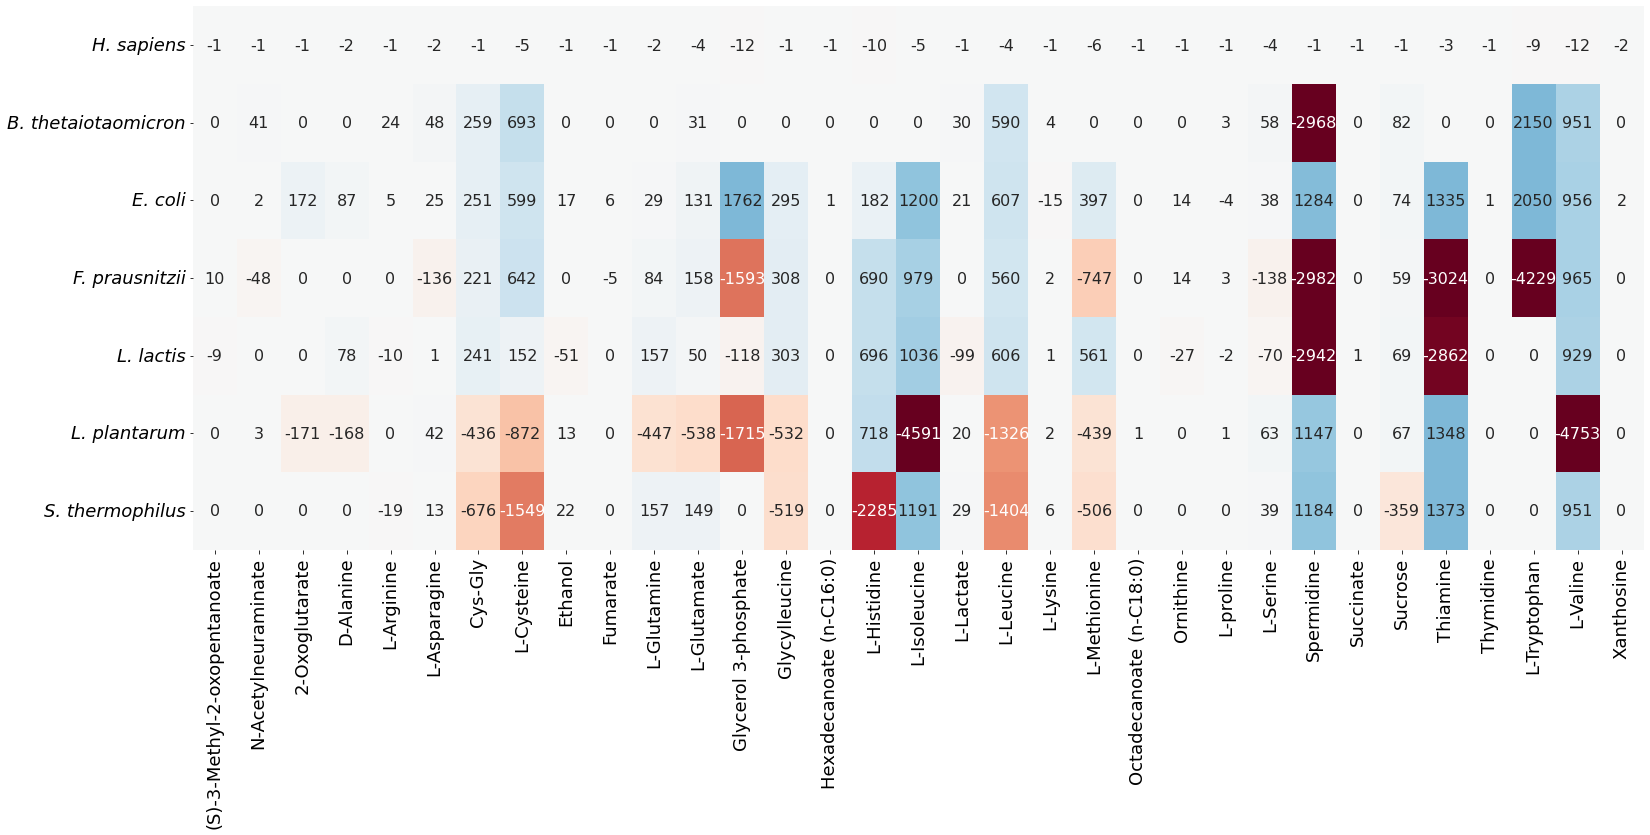

In [13]:
# Check the number of MPs that include each metabolite
fig = plt.figure()
ax = sns.heatmap(HS_mat.T, robust = True, cmap='RdBu', annot=True, fmt='.0f', annot_kws=dict(size=16), cbar=False, center=0)
ax.set_yticklabels([o[0] + '. ' + o.split(' ')[1] for o in HS_mat.columns], style='italic', fontdict={'fontsize': 18})
ax.set_xticklabels(HS_mat.index, fontdict={'fontsize':18})
fig.set_size_inches(26,10)
fig.savefig('results/figures/IEX_randsamp', bbox_inches='tight')

In [14]:
# Build matrix for heatmap
sub_mat = my_mat_df.loc[mets1.keys(),]
sub_mat

HS      BT      EC      FP      LL      LP      ST
ala_L  0.0     0.0   134.0  -228.0    87.0  -159.0   132.0
etoh  -1.0     0.0    17.0     0.0   -51.0    13.0    22.0
for    0.0     0.0     2.0    -2.0    -1.0     1.0     0.0
gly    0.0     0.0     9.0    21.0   -38.0    19.0   -13.0
glyc   0.0     0.0    30.0     2.0   -49.0    17.0     0.0
ile_L -5.0     0.0  1200.0   979.0  1036.0 -4591.0  1191.0
nac    0.0  1631.0  1681.0 -4225.0  -674.0 -1830.0    68.0
orn   -1.0     0.0    14.0    14.0   -27.0     0.0     0.0
succ  -1.0     0.0     0.0     0.0     1.0     0.0     0.0

In [15]:
# Load MPs from Øyås & Stelling
mps = set()
with open('raw_data_from_publications/HS_BT_EC_FP_LL_LP_ST_copy_20220302_144207918751_complete_mps.csv', 'r') as f:
    for line in f:
        mps.add(frozenset(line.strip().split(',')))
len(mps)

252

In [16]:
# Build matrix for heatmap
d = {k: defaultdict(int) for k in organisms}
for mp in mps:
    for x in mp:
        org = x[:2]
        met = x[7:]
        if x.endswith('_rev'):
            met = met[:-4]
            c = -1
        else:
            c = 1
        d[org][met] += c
mat_df = pd.DataFrame(d).fillna(0).sort_index()

In [17]:
mat_df

HS     BT     EC     FP     LL     LP     ST
ala_L    0.0    0.0 -252.0 -252.0    0.0    0.0  252.0
etoh     0.0    0.0 -252.0    0.0    0.0    0.0  252.0
for   -120.0   24.0    0.0   24.0   24.0   24.0   24.0
gly    -12.0    0.0    0.0 -252.0  120.0    0.0  132.0
glyc   -48.0    0.0    0.0   24.0   24.0    0.0    0.0
ile_L    0.0    0.0  -63.0  -63.0  252.0  -63.0  -63.0
mal_L -108.0    0.0    0.0    0.0    0.0  108.0    0.0
nac      0.0 -252.0   84.0 -252.0   84.0    0.0   84.0
orn   -252.0    0.0    0.0 -252.0  252.0    0.0    0.0
ppa    -24.0    0.0    0.0    0.0   24.0    0.0    0.0
succ   -48.0    0.0    0.0   24.0   24.0    0.0    0.0

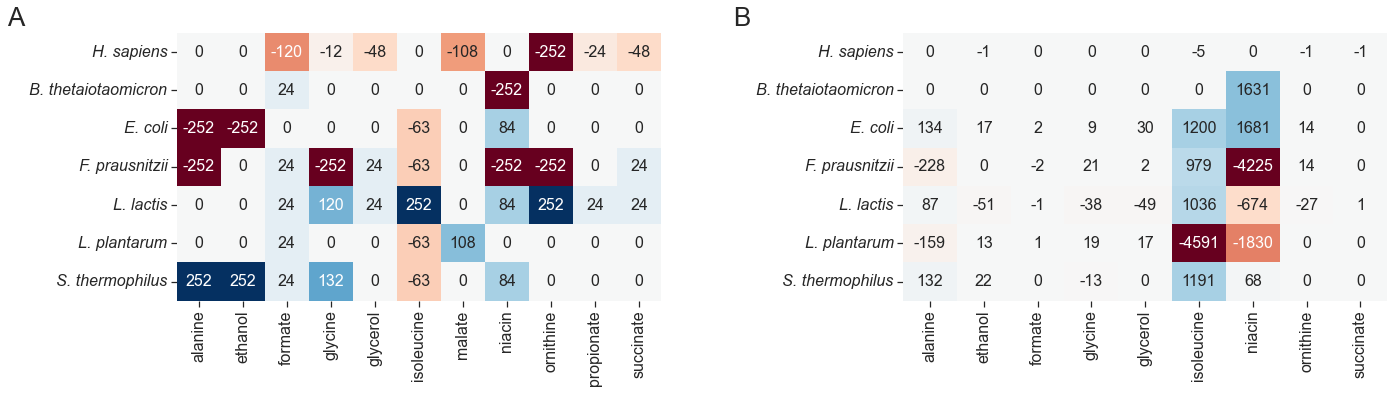

In [21]:
sns.set(style='ticks', font_scale=2)
f = plt.figure()

plt.subplot(1, 2, 1)

label_x = -0.35
label_y = 1.025
label_size = 26

ax = sns.heatmap(mat_df.T, cmap='RdBu', robust=True, annot=True, fmt='.0f', annot_kws=dict(size=16), cbar=False)
#sns.heatmap((mat_df.T / len(mps)).abs(), cmap='RdBu', center=0, annot=True, fmt='.1f', annot_kws=dict(size=16), cbar=False, ax=ax, alpha=0)
ax.text(label_x, label_y, 'A', transform=ax.transAxes, size=label_size)
yticklabels = []
for x in ax.get_yticklabels():
    o = organisms[x.get_text()] 
    yticklabels.append(o[0] + '. ' + o.split(' ')[1])
ax.set_yticklabels(yticklabels, rotation=0, style='italic', fontdict={'fontsize': 16})
ax.set_xticks(np.arange(0.5, len(mets2), 1))
ax.set_xticklabels([mets2[x] for x in mat_df.index], fontdict={'fontsize': 16})

plt.subplot(1, 2, 2)

ax = sns.heatmap(sub_mat.T, cmap='RdBu', robust=True, center=0, annot=True, fmt='.0f', annot_kws=dict(size=16), cbar=False)
ax.text(label_x, label_y, 'B', transform=ax.transAxes, size=label_size)
yticklabels = []
for x in ax.get_yticklabels():
    o = organisms[x.get_text()] 
    yticklabels.append(o[0] + '. ' + o.split(' ')[1])
ax.set_yticklabels(yticklabels, rotation=0, style='italic', fontdict={'fontsize': 16})
ax.set_xticks(np.arange(0.5, len(mets1), 1))
ax.set_xticklabels([mets1[key] for key in mets1.keys() if key in mat_df.index], fontdict={'fontsize': 16})


f.set_size_inches(20, 6)
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
f.savefig('results/figures/compare_mps_hm_model', bbox_inches='tight')

Øyås, O., & Stelling, J. (2020). Scalable metabolic pathway analysis. bioRxiv, 2020.2007.2031.230177. https://doi.org/10.1101/2020.07.31.230177